# This notebook contains all the code to train the model using the advanced pipeline.  

In [ ]:
# This section contains the list of modules and imports require to execute the code.

# We ignored some warnings.
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="libpng warning: iCCP: known incorrect sRGB profile")
warnings.filterwarnings("ignore", message="'rm' is not recognized as an")

# We run the code on the CPU, so the following 2 lines disable GPU-based execution.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from pylab import rcParams
from PIL import Image
import tensorflow as tf
import os
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import numpy as np
import tensorflow as tf
tf.random.set_seed(seed_value)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# CV2 module is required to read PNG images.
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [ ]:
# This section contains helper functions.

# Plot the confusion matrix.
def textplotting(model,x_test,y_test):
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    y_pred = y_pred.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    print(confusion_matrix(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))

# Plot the confusion matrix.
def metric(best_model,x_train,y_train,x_test,y_test):

  y_pred = best_model.predict(x_test)
  sn.set(font_scale=2)
  rcParams['figure.figsize'] = 7, 7
  confusion_matrix = pd.crosstab(y_test.argmax(axis=1), y_pred.argmax(axis=1), rownames=['Actual'], colnames=['Predicted'])
  sn.heatmap(confusion_matrix, annot=True)

  plt.savefig("Test.png")
  plt.clf()
  confusion_matrix = pd.crosstab(y_train.argmax(axis=1), best_model.predict(x_train).argmax(axis=1), rownames=['Actual'], colnames=['Predicted'])
  sn.heatmap(confusion_matrix, annot=True)

  plt.savefig("Train.png")
  plt.clf()

# Plot the parameter reduction.
def simplot(parameterslist):
    plt.clf()
    sn.set(font_scale=1)
    rcParams['figure.figsize'] = 10, 10
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    lists = sorted(parameterslist.items()) 
    x, y = zip(*lists)  
    plt.minorticks_on() 
    fig,ax=plt.subplots()
    ax.plot(x, y, marker="o")
    ax.grid(True)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('1') 
    ax.set_xscale('log')
    ax.set_xlabel("Number of Parameters")
    ax.set_ylabel("Accuracy")
    plt.savefig("Parameters.png")
    plt.show()

# Save parameter reduction file in a particular format.
def saveLogfile(NeuronsInLayer1,NeuronsInLayer2,IntermediateAccuracy,IntermediateParameters):
    data = np.column_stack([NeuronsInLayer1,NeuronsInLayer2,IntermediateAccuracy,IntermediateParameters])
    datafile_path = "./Logfile.txt"
    np.savetxt(datafile_path , data, fmt=['%f','%d','%f','%d']) 


# This segment is used to place images in specific directories.
def makedirectory(name,x_train,y_train,x_test, y_test,x_val, y_val):
    base_dir = './fold'+str(name)
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)


    train_dir = os.path.join(base_dir, 'train')
    if not os.path.isdir(train_dir):
        os.mkdir(train_dir)


    validation_dir = os.path.join(base_dir, 'validation')
    if not os.path.isdir(validation_dir):
        os.mkdir(validation_dir)


    test_dir = os.path.join(base_dir, 'test')
    if not os.path.isdir(test_dir):
        os.mkdir(test_dir)



    # Make a folder for train,test, and validation set for each category.
    for loop in folders:
         temptrain = os.path.join(train_dir, loop)
         if not os.path.isdir(temptrain):
             os.mkdir(temptrain)
         tempvalid = os.path.join(validation_dir, loop)
         if not os.path.isdir(tempvalid):
             os.mkdir(tempvalid)
         temptest = os.path.join(test_dir, loop)

         if not os.path.isdir(temptest):
             os.mkdir(temptest)

         for loop2 in range(0,len(y_train)):
            if y_train[loop2]==loop:
                im = Image.fromarray(x_train[loop2])
                im.save(temptrain+os.sep+str(loop2)+".jpeg")               
         for loop2 in range(0,len(y_test)):
            if y_test[loop2]==loop:
                im = Image.fromarray(x_test[loop2])
                im.save(temptest+os.sep+str(loop2)+".jpeg")
         for loop2 in range(0,len(y_val)):
            if y_val[loop2]==loop:
                im = Image.fromarray(x_val[loop2])
                im.save(tempvalid+os.sep+str(loop2)+".jpeg")

# Read images
def load_images_from_folder(folder,shape):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (shape, shape))
            images.append(img)

    return images

# Step 1 - Train the model.

In [ ]:

# The folders in which images are placed.
folders = [
  'CT_COVID',
  'CT_NonCOVID',
]



label_encoder = LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')

# Any number of image generators can be specified and used, but we used 4 different image augmentation architectures.
gen=[1,2,3,4]

# Images can be reshaped to various sizes to reduce the training time and neural network size.
shapes = [50,100,200]


# For each shape
for shape in shapes:
  print("Shape:",shape)
  X = load_images_from_folder(folders[0],shape)
  Y = [folders[0]]*len(X)
  cat = 1
  for loop in range(1,len(folders)):
     print("Processing : ",folders[loop]) 
     tempX = load_images_from_folder(folders[loop],shape)
     tempY = [folders[loop]]*len(tempX)
     Y = Y + tempY 
     X = X + tempX

  X = np.array(X)
  Y= np.array(Y)
  skf = StratifiedKFold(n_splits=5)
  skf.get_n_splits(X, Y)
  fold_no = 1
  acc_per_fold = {}
  loss_per_fold = {}
  input_shape = (shape , shape , 3)

  # For cross validation
  for train_index, test_index in skf.split(X, Y):
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = Y[train_index], Y[test_index]
     x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
     makedirectory(str(fold_no)+"_"+str(shape),x_train,y_train,x_test, y_test,x_val, y_val)
     train_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'train')
     validation_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'validation')
     test_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'test') 
     y_train = to_categorical(label_encoder.fit_transform(y_train))
     y_test = to_categorical(label_encoder.fit_transform(y_test))
     y_val = to_categorical(label_encoder.fit_transform(y_val))

     model = Sequential()
     model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Flatten())  
     model.add(Dense(128, activation=tf.nn.relu))
     model.add(Dropout(0.2))
     model.add(Dense(len(folders),activation=tf.nn.softmax))

     # For each generator
     for selectgen in gen:
        batch_size=5
        if selectgen==1:
           train_datagen = ImageDataGenerator(
           rescale=1./255)
           test_datagen = ImageDataGenerator(rescale=1./255)
        elif selectgen==2:
           train_datagen = ImageDataGenerator(
           rescale=1./255,
           rotation_range=40,
           brightness_range=[0.2,1.0],
           horizontal_flip=True,
           vertical_flip=True,
           fill_mode='nearest')
           test_datagen = ImageDataGenerator(rescale=1./255)
        elif selectgen==3:
           train_datagen = ImageDataGenerator(
           rescale=1./255,
           rotation_range=40,
           featurewise_center=True,
           featurewise_std_normalization=True,
           brightness_range=[0.2,1.0],
           horizontal_flip=True,
           vertical_flip=True,
           fill_mode='nearest')
           test_datagen = ImageDataGenerator(rescale=1./255)
        else:
           train_datagen = ImageDataGenerator(
           rescale=1./255,
           rotation_range=40,
           width_shift_range=0.2,
           height_shift_range=0.2,
           shear_range=0.2,
           featurewise_center=True,
           featurewise_std_normalization=True,
           zoom_range=0.2,
           brightness_range=[0.2,1.0],
           horizontal_flip=True,
           vertical_flip=True,
           fill_mode='nearest')
           test_datagen = ImageDataGenerator(rescale=1./255)        


           train_generator = train_datagen.flow_from_directory(
           train_dir,
           target_size=(shape , shape ),
           batch_size=batch_size,
           class_mode='categorical')

           validation_generator = test_datagen.flow_from_directory(
           validation_dir,
           target_size=(shape , shape ),
           batch_size=batch_size,
           class_mode='categorical')

           model.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

           history = model.fit_generator(
               train_generator,
               steps_per_epoch=train_generator.n // batch_size,
               epochs=15,
               validation_data=validation_generator,
               validation_steps=validation_generator.n // batch_size,
               verbose=0)

           #print("DONE")
           test_generator = test_datagen.flow_from_directory(
               test_dir,
               target_size=(shape , shape),
               batch_size=batch_size ,
               class_mode='categorical')

        test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
        print('test acc:', test_acc)
        if selectgen not in acc_per_fold:
           acc_per_fold[selectgen] = [test_acc * 100]
           loss_per_fold[selectgen] = [test_loss]
        else:
           acc_per_fold[selectgen].append(test_acc * 100)
           loss_per_fold[selectgen].append(test_loss)
     #os.system("rm -rf fold"+str(fold_no)+"_"+str(shape))
     fold_no = fold_no + 1    

  # For each generator, print the results for each fold.   
  for g in gen:
     print("Generator",g)
     acc_per_foldt = acc_per_fold[g] 
     loss_per_foldt = loss_per_fold[g]   
     print('------------------------------------------------------------------------')
     print('Score per fold')
     for i in range(0, len(acc_per_foldt)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_foldt[i]} - Accuracy: {acc_per_foldt[i]}%')
     print('------------------------------------------------------------------------')
     print('Average scores for all folds:')
     print(f'> Accuracy: {np.mean(acc_per_foldt)} (+- {np.std(acc_per_foldt)})')
     print(f'> Loss: {np.mean(loss_per_foldt)}')
     print('------------------------------------------------------------------------')

# Step 2 - Find the Best Model And reduce the model's size

In [ ]:
# From the previous step, use the best generator and shape depending on the deployment.
# For example, generator 1 is not feasible for real images because images can be various rotations when captured through a phone.
# For medical images, if we reduce the shape size, then many different classes may converge to the same class.

gen = [1]
shapes = [50]
for shape in shapes:
    X = load_images_from_folder(folders[0],shape)
    Y = [folders[0]]*len(X)
    cat = 1
    for loop in range(1,len(folders)):
         print("Processing : ",folders[loop]) 
         tempX = load_images_from_folder(folders[loop],shape)
         tempY = [folders[loop]]*len(tempX)
         Y = Y + tempY 
         X = X + tempX

    X = np.array(X)
    Y= np.array(Y)
    skf = StratifiedKFold(n_splits=5)
    input_shape = (shape , shape , 3)
    for selectgen in gen:
        batch_size=5
        NeuronsInLayer1 = []
        NeuronsInLayer2 = []
        IntermediateAccuracy = []
        IntermediateParameters = []
        parameterslist = {}
        # Change the number of neurons in the first and the second layer.
        # If you use an existing architecture, then there is no need to reduce the number of neurons in each layer.
        for loop in range(1,20):
            for loop2 in range(1,20):
               acc_per_fold = []
               loss_per_fold = []
               fold_no = 0
               for train_index, test_index in skf.split(X, Y):
                   x_train, x_test = X[train_index], X[test_index]
                   y_train, y_test = Y[train_index], Y[test_index]
                   x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
                   makedirectory(str(fold_no)+"_"+str(shape),x_train,y_train,x_test, y_test,x_val, y_val)
                   train_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'train')
                   validation_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'validation')
                   test_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'test') 
                   y_train = to_categorical(label_encoder.fit_transform(y_train))
                   y_test = to_categorical(label_encoder.fit_transform(y_test))
                   y_val = to_categorical(label_encoder.fit_transform(y_val))
                   #print("Shape  ",str(shape))
                   model = Sequential()
                   model.add(Conv2D(loop, kernel_size=(3,3), input_shape=input_shape))
                   model.add(MaxPooling2D(pool_size=(2, 2)))
                   model.add(Flatten())  
                   model.add(Dense(loop2, activation=tf.nn.relu))
                   model.add(Dropout(0.2))
                   model.add(Dense(len(folders),activation=tf.nn.softmax))
                   param = model.count_params()


                   if selectgen==1:
                      train_datagen = ImageDataGenerator(
                      rescale=1./255)
                      test_datagen = ImageDataGenerator(rescale=1./255)
                   elif selectgen==2:
                      train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=40,
                      brightness_range=[0.2,1.0],
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
                      test_datagen = ImageDataGenerator(rescale=1./255)
                   elif selectgen==3:
                      train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=40,
                      featurewise_center=True,
                      featurewise_std_normalization=True,
                      brightness_range=[0.2,1.0],
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
                      test_datagen = ImageDataGenerator(rescale=1./255)
                   else:
                      train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=40,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.2,
                      featurewise_center=True,
                      featurewise_std_normalization=True,
                      zoom_range=0.2,
                      brightness_range=[0.2,1.0],
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
                      test_datagen = ImageDataGenerator(rescale=1./255)     


                   train_generator = train_datagen.flow_from_directory(
                   train_dir,
                   target_size=(shape , shape ),
                   batch_size=batch_size,
                   class_mode='categorical')

                   validation_generator = test_datagen.flow_from_directory(
                   validation_dir,
                   target_size=(shape , shape ),
                   batch_size=batch_size,
                   class_mode='categorical')

                   model.compile(optimizer='adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

                   history = model.fit_generator(
                       train_generator,
                       steps_per_epoch=train_generator.n // batch_size,
                       epochs=15,
                       validation_data=validation_generator,
                       validation_steps=validation_generator.n // batch_size,
                       verbose=0)

                   #print("DONE")
                   test_generator = test_datagen.flow_from_directory(
                       test_dir,
                       target_size=(shape , shape),
                       batch_size=batch_size ,
                       class_mode='categorical')

                   test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size)
                   #print('test acc:', test_acc)
                   acc_per_fold.append(test_acc * 100)
                   loss_per_fold.append(test_loss)
                   fold_no = fold_no + 1   
               print(fold_no)
               print(str(int(np.mean(acc_per_fold))),loop,loop2,param) 
               NeuronsInLayer1.append(loop)
               NeuronsInLayer2.append(loop2)     
               IntermediateAccuracy.append(int(np.mean(acc_per_fold)))
               IntermediateParameters.append(param)
               parameterslist[str(model.count_params())] = int(np.mean(acc_per_fold))

        saveLogfile(NeuronsInLayer1,NeuronsInLayer2,IntermediateAccuracy,IntermediateParameters)
        parameterslist = dict(sorted(parameterslist.items()))
        simplot(parameterslist)

        # We can save any model for the 5 fold validation, so we exit the code after the training of the first fold.

        exit(0)

# Step 2 - Plot parameter reduction

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import math 
import matplotlib.pyplot as plt
data = pd.read_csv("LogFile.txt",sep="\s+",header=None)
print(data)
data2 = data[2].values
data2 =data2.reshape(int(math.sqrt(len(data))),int(math.sqrt(len(data))))
ax = sns.heatmap(data2, cmap="YlGnBu")
ax.set(xlabel="Neurons in the second layer", ylabel = "Filters in the first layer")
ax.set_xlim(1, int(math.sqrt(len(data)))+1)
ax.set_ylim(1, int(math.sqrt(len(data)))+1)
plt.show()

 # Step 3 - Convet Model to TFlite And AddDetadata

In [ ]:
gen = [1]
shapes = [50]
for shape in shapes:
X = load_images_from_folder(folders[0],shape)
Y = [folders[0]]*len(X)
cat = 1
for loop in range(1,len(folders)):
     print("Processing : ",folders[loop]) 
     tempX = load_images_from_folder(folders[loop],shape)
     tempY = [folders[loop]]*len(tempX)
     Y = Y + tempY 
     X = X + tempX

X = np.array(X)
Y= np.array(Y)
skf = StratifiedKFold(n_splits=5)
input_shape = (shape , shape , 3)
for selectgen in gen:
    batch_size=5
    acc_per_fold = []
    loss_per_fold = []
    fold_no = 0
    for train_index, test_index in skf.split(X, Y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
        makedirectory(str(fold_no)+"_"+str(shape),x_train,y_train,x_test, y_test,x_val, y_val)
        train_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'train')
        validation_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'validation')
        test_dir = os.path.join("fold"+str(fold_no)+"_"+str(shape), 'test') 
        y_train = to_categorical(label_encoder.fit_transform(y_train))
        y_test = to_categorical(label_encoder.fit_transform(y_test))
        y_val = to_categorical(label_encoder.fit_transform(y_val))
        #print("Shape  ",str(shape))
        model = Sequential()

        # Use the best number of neurons for the first layer in this layer obtained from the previous step.
        model.add(Conv2D(2, kernel_size=(3,3), input_shape=input_shape))
        # Use the best number of neurons for the second layer in this layer obtained from the previous step.
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())  
        model.add(Dense(17, activation=tf.nn.relu))
        model.add(Dropout(0.2))
        model.add(Dense(2,activation=tf.nn.softmax))
        param = model.count_params()


        if selectgen==1:
           train_datagen = ImageDataGenerator(
           rescale=1./255)
           test_datagen = ImageDataGenerator(rescale=1./255)
        elif selectgen==2:
           train_datagen = ImageDataGenerator(
           rescale=1./255,
           rotation_range=40,
           brightness_range=[0.2,1.0],
           horizontal_flip=True,
           vertical_flip=True,
           fill_mode='nearest')
           test_datagen = ImageDataGenerator(rescale=1./255)
        elif selectgen==3:
           train_datagen = ImageDataGenerator(
           rescale=1./255,
           rotation_range=40,
           featurewise_center=True,
           featurewise_std_normalization=True,
           brightness_range=[0.2,1.0],
           horizontal_flip=True,
           vertical_flip=True,
           fill_mode='nearest')
           test_datagen = ImageDataGenerator(rescale=1./255)
        else:
           train_datagen = ImageDataGenerator(
           rescale=1./255,
           rotation_range=40,
           width_shift_range=0.2,
           height_shift_range=0.2,
           shear_range=0.2,
           featurewise_center=True,
           featurewise_std_normalization=True,
           zoom_range=0.2,
           brightness_range=[0.2,1.0],
           horizontal_flip=True,
           vertical_flip=True,
           fill_mode='nearest')
           test_datagen = ImageDataGenerator(rescale=1./255)     


        train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(shape , shape ),
        batch_size=batch_size,
        class_mode='categorical')

        validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(shape , shape ),
        batch_size=batch_size,
        class_mode='categorical')

        model.compile(optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

        history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=validation_generator.n // batch_size,
            verbose=0)

        #print("DONE")
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=(shape , shape),
            batch_size=batch_size ,
            class_mode='categorical')

        test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size)

        acc_per_fold.append(test_acc * 100)
        loss_per_fold.append(test_loss)
        fold_no = fold_no + 1   

        ### In this step we will simply save the model
        model_save_path = "./"
        tf.saved_model.save(model, model_save_path) 
        converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path)
        tflite_model = converter.convert() 

        # Save the simple model.
        open("model.tflite", "wb").write(tflite_model)

        # Generate Quantized Model
        import tensorflow_model_optimization as tfmot
        quantize_model = tfmot.quantization.keras.quantize_model

        # q_aware stands for for quantization aware.
        q_aware_model = quantize_model(model)
        # `quantize_model` requires a recompile.
        q_aware_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        history = q_aware_model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_generator.n // batch_size,
            verbose=1)
        q_aware_model.summary()

        _, baseline_model_accuracy = model.evaluate(x_test/255, y_test, verbose=0)
        _, q_aware_model_accuracy = q_aware_model.evaluate(x_test/255, y_test, verbose=0)

        print('Baseline test accuracy:', baseline_model_accuracy)
        print('Quant test accuracy:', q_aware_model_accuracy)            

        textplotting(model,x_train/255,y_train)
        textplotting(model,x_test/255,y_test)
        textplotting(q_aware_model,x_train/255,y_train)
        textplotting(q_aware_model,x_test/255,y_test)

        #q_aware_model.save("qalsome.hd5")
        ### In this step we will simply save the model
        model_save_path = "./"
        tf.saved_model.save(q_aware_model, model_save_path) 
        converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path)
        tflite_model = converter.convert() 
        # Save the quantized model.
        open("qmodel.tflite", "wb").write(tflite_model) 

        # We can save any model for the 5 fold validation, so we exit the code after the training of the first fold.


        # We can save any model for the 5 fold validation, so we exit the code after the training of the first fold.





 # Step 3 -  Add Metadata to Model

In [1]:
import os
# Change values in metadata_writer_for_image_classifier.py 
#_MODEL_INFO = {
#    "model.tflite":
#        ModelSpecificInfo(
#            name="model",
#            version="v1",
#            image_width=100,
#            image_height=100,
#            image_min=0,
#            image_max=255,
#            mean=[127.5],
#            std=[127.5],
#            num_classes=2,
#            author="Alpha")
#}

# Change labels in labels.txt file

os.mkdir("Finalmodel")
os.system("python ./metadata_writer_for_image_classifier.py --model_file=model.tflite --label_file=labels.txt --export_directory=./Finalmodel")


1

# Step 4 - Make Android Application

The following picture shows the android studio, and we have to change the assets. Replace the Labels.txt file with current Labels.txt and place the Finalmodel/model with efficientnet-lite0-int8 and rename the model to efficientnet-lite0-int8.

Replace
G:\Application\Final\Image-Classification-master\models\src\main\assets\efficientnet-lite0-int8

With
Finalmodel/model and rename model with efficientnet-lite0-int8

Open Android studio and open Image-Classificaion-master, build the application.


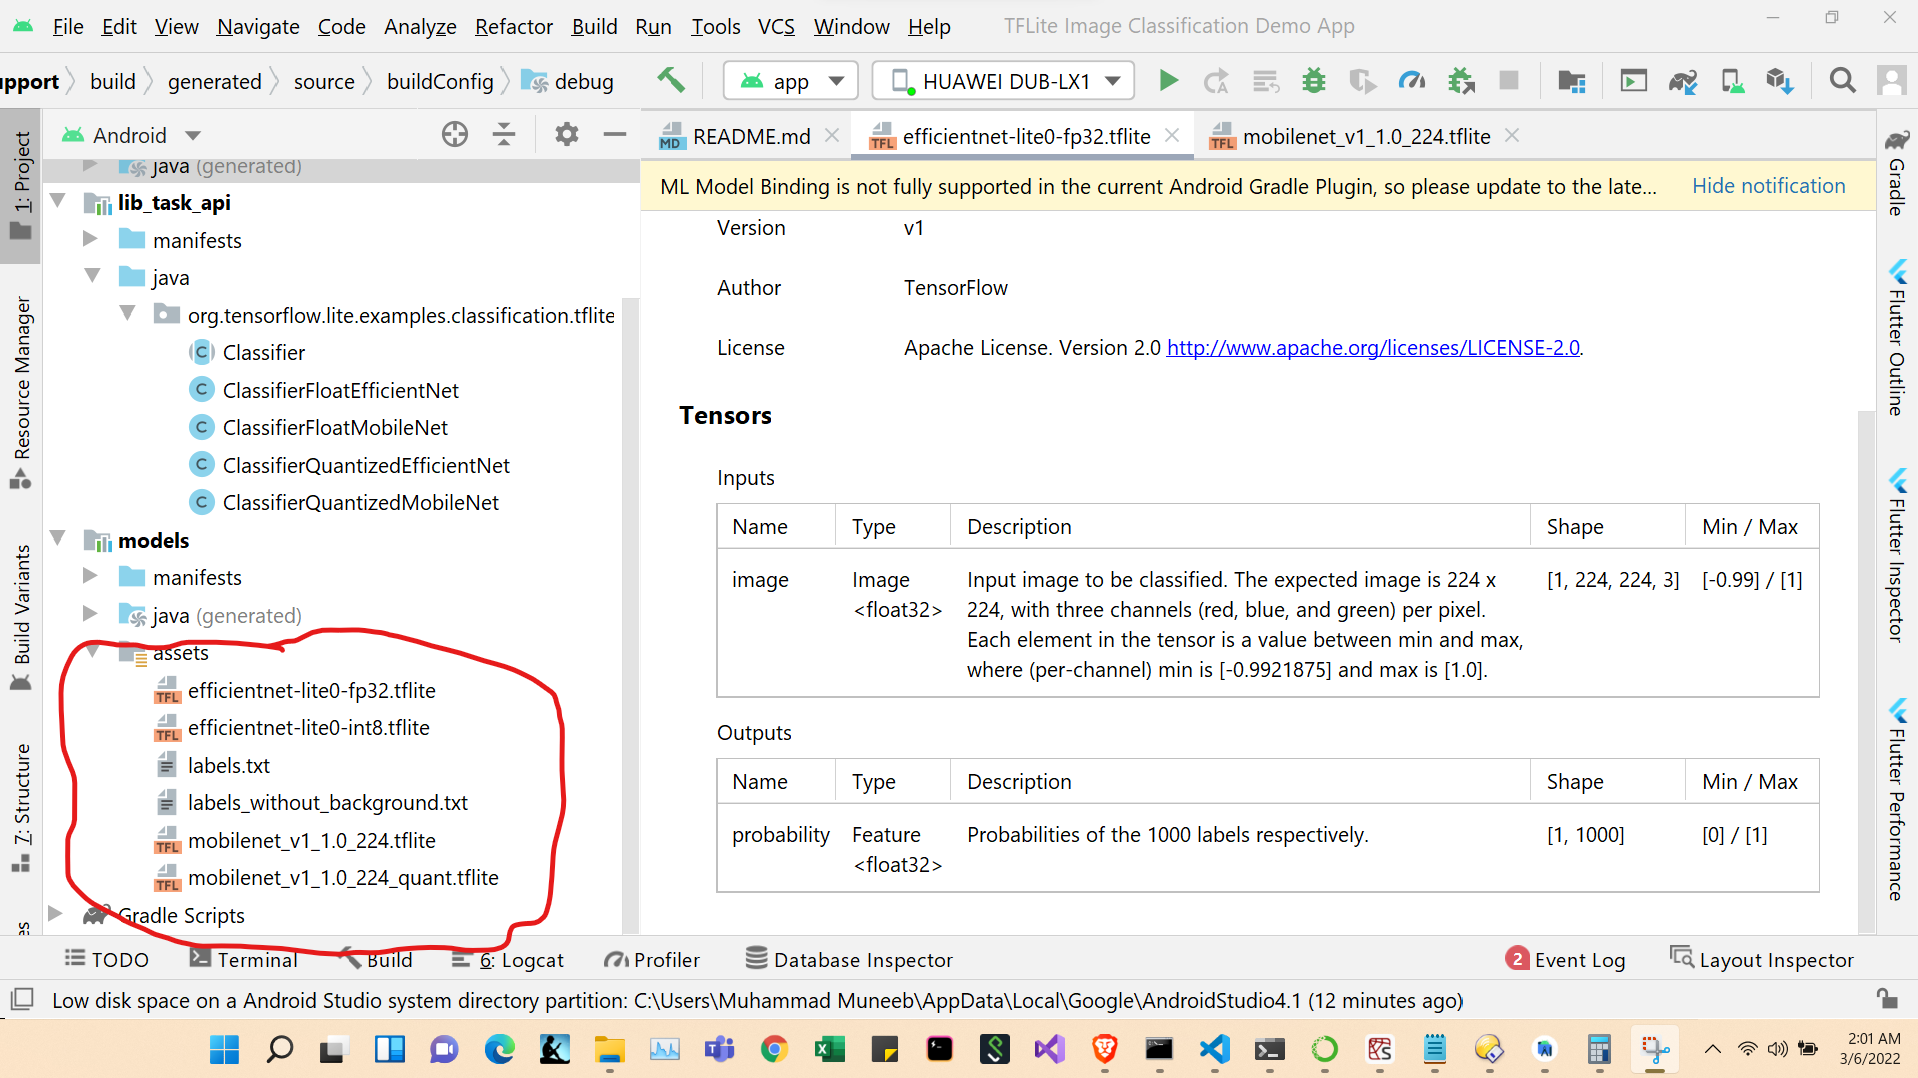 

The following picture shows the directory structure. CT_COVID and CT_NonCOVID contain the original images. Fold*_* shows temporary images. Logfile shows the logfiles. 

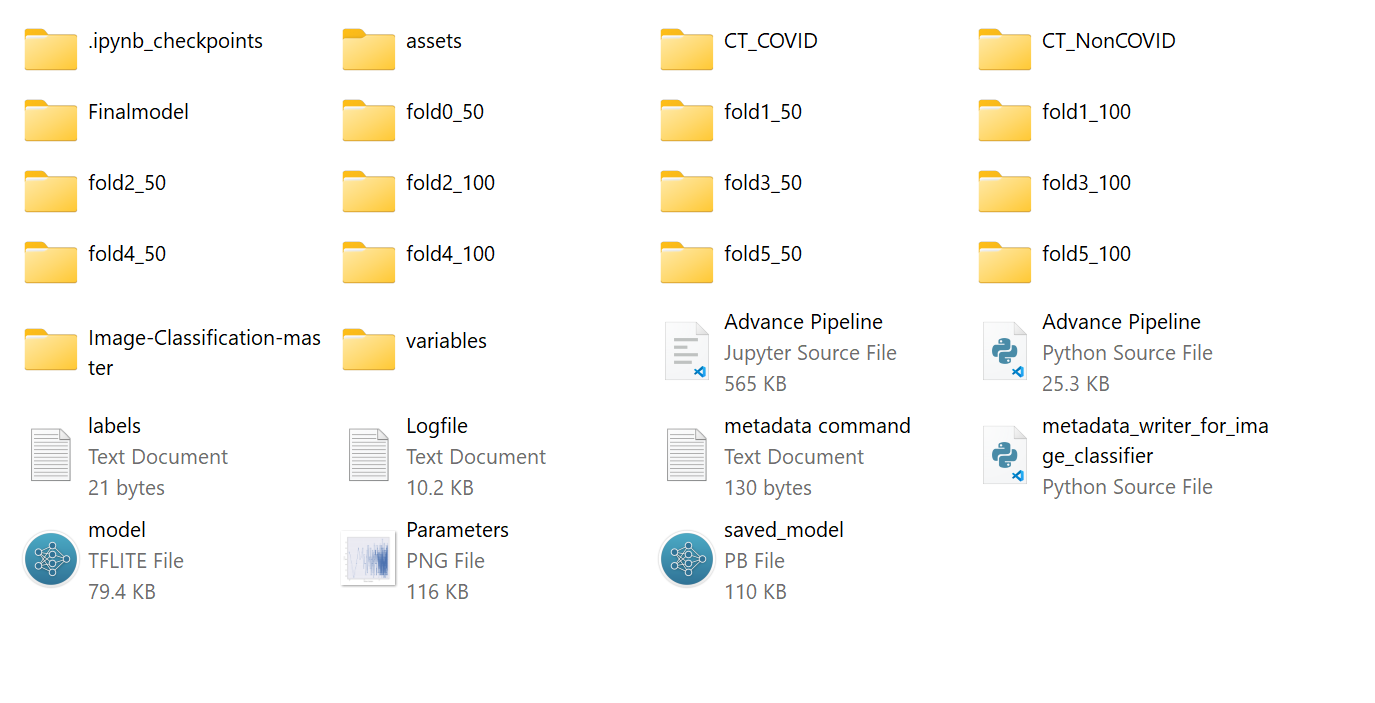

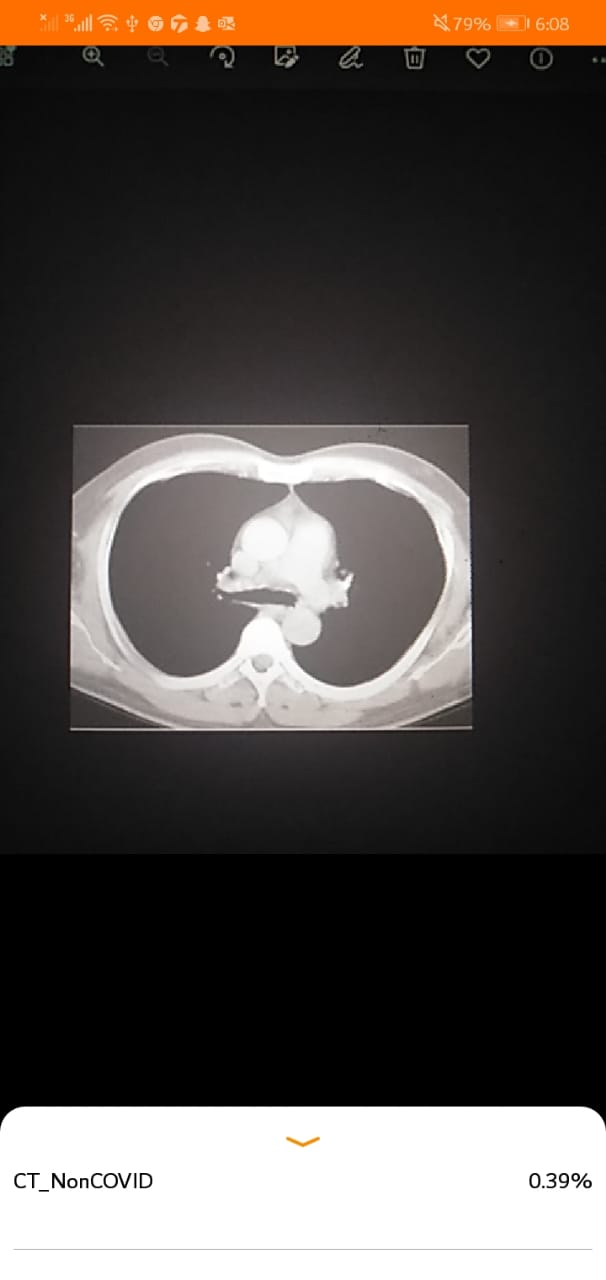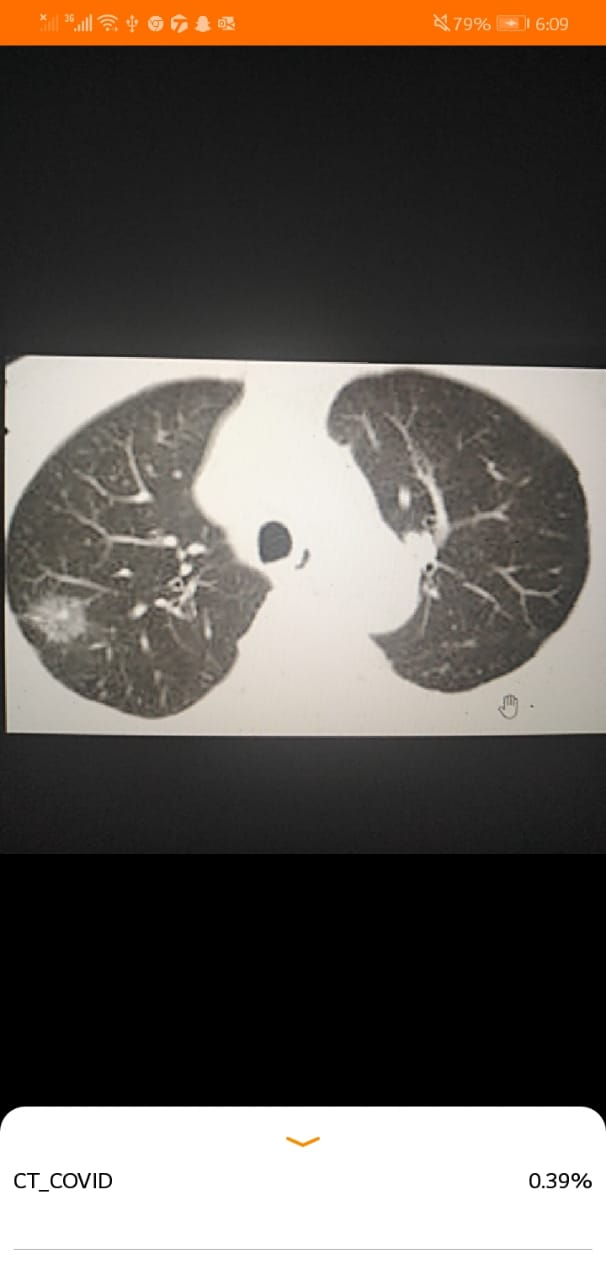

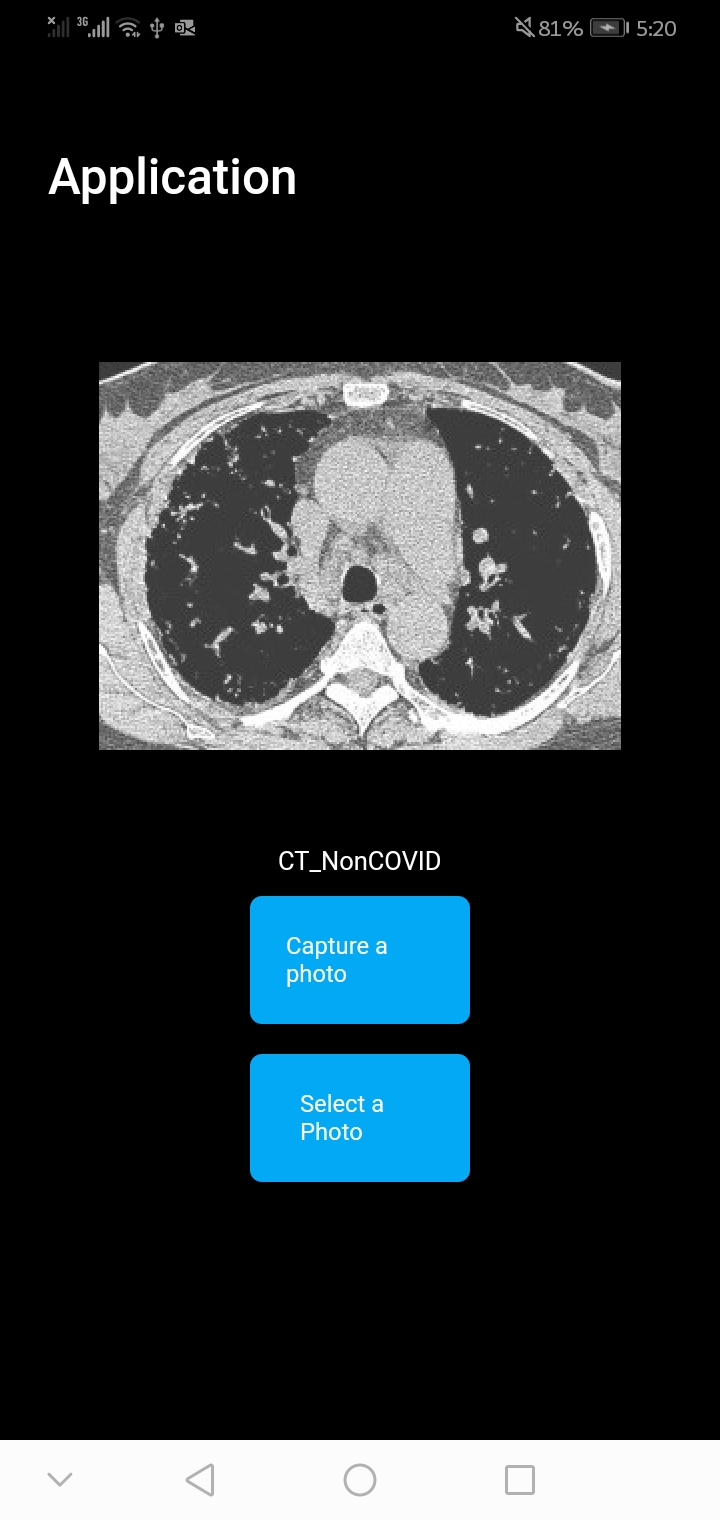


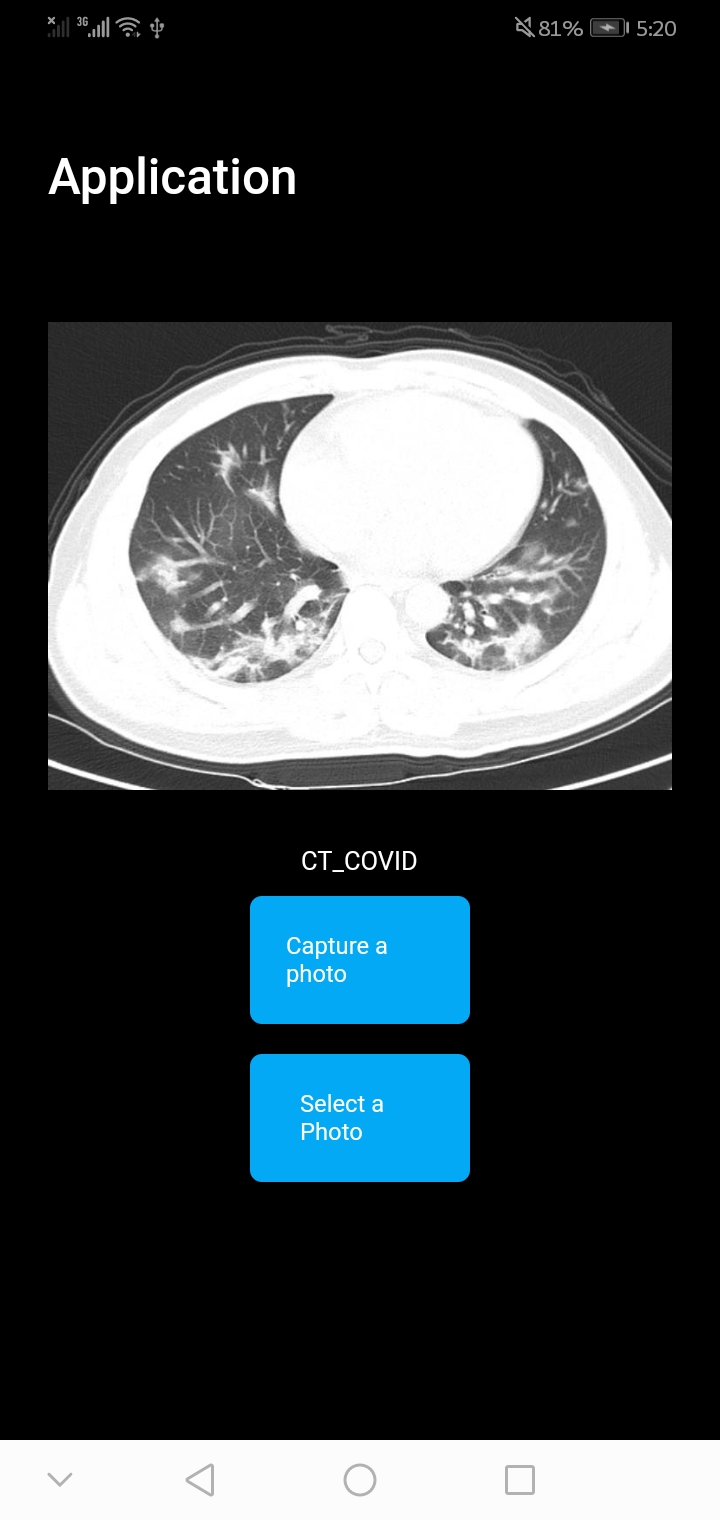
